## Feature Engneeringなしでの、それぞれの分類器の精度検証

Deep Analyticsの練習問題: https://deepanalytics.jp/compe/1?tab=compedetail

#### 検証した分類器

- K Nearest Neighbors
- Logistic Regression
- Naive Bayes
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- AdaBoost
- Gradient Boosting
- Random Forest

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import multiprocessing
import numpy as np
import pandas as pd
from scipy import interp
from patsy import dmatrices
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [3]:
# 質的変数をダミー変数化
y, X = dmatrices('y ~ age + job + marital + education + default + balance + housing + loan + contact + day + month + duration + campaign + pdays + previous + poutcome', data=train_df, return_type='dataframe')
X_ = X.values
y_ = y.y.values

X.head()

,Intercept,job[T.blue-collar],job[T.entrepreneur],job[T.housemaid],job[T.management],job[T.retired],job[T.self-employed],job[T.services],job[T.student],job[T.technician],...,poutcome[T.other],poutcome[T.success],poutcome[T.unknown],age,balance,day,duration,campaign,pdays,previous
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,39.0,1756.0,3.0,939.0,1.0,-1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,51.0,1443.0,18.0,172.0,10.0,-1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,36.0,436.0,13.0,567.0,1.0,595.0,2.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,63.0,474.0,25.0,423.0,1.0,-1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,31.0,354.0,30.0,502.0,1.0,9.0,2.0


## Cross ValidationでROC曲線を描く

参考: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [4]:
def evaluate_model(classifier, n_folds=6):
    cv = StratifiedKFold(y_, n_folds=n_folds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    print("Calculating fold: ", end="")
    for i, (train, test) in enumerate(cv):
        print(i+1, end=" ")
        classifier.fit(X_[train], y_[train])
        try:
            probas_ = classifier.predict_proba(X_[test])[:, 1]
        except:
            probas_ = classifier.decision_function(X_[test])
            print(probas_)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_[test], probas_)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.3f)' % (i, roc_auc))

    print("done!", end="")
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.3f)' % mean_auc, lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Calculating fold: 1 2 3 4 5 6 done!

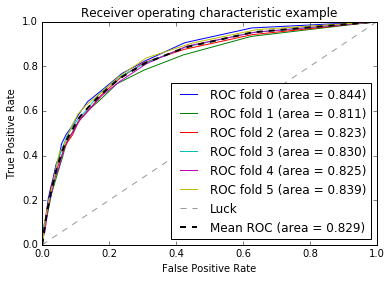

In [5]:
# K Nearest Neighbors
evaluate_model(KNeighborsClassifier(30, n_jobs=multiprocessing.cpu_count()))

Calculating fold: 1 2 3 4 5 6 done!

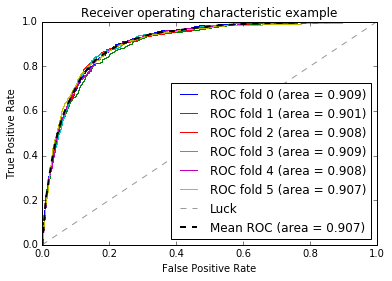

In [6]:
# Logistic Regression
evaluate_model(LogisticRegression(penalty='l1', C=1, n_jobs=multiprocessing.cpu_count()))

Calculating fold: 1 2 3 4 5 6 done!

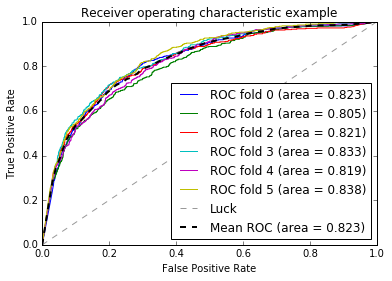

In [7]:
# GaussianNB
evaluate_model(GaussianNB())

Calculating fold: 1 

/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


2 3 4 5 6 done!

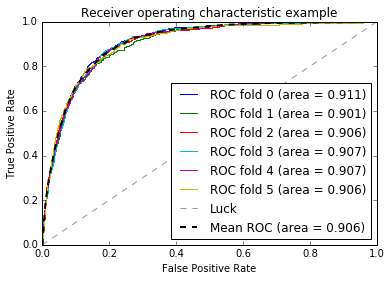

In [8]:
# LinearDiscriminantAnalysis
evaluate_model(LinearDiscriminantAnalysis())

Calculating fold: 1 

/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2 3 4 5 6 done!

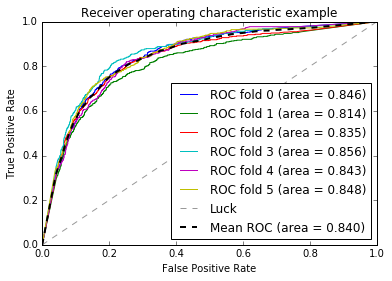

In [9]:
# QuadraticDiscriminantAnalysis
evaluate_model(QuadraticDiscriminantAnalysis())

Calculating fold: 1 2 3 4 5 6 done!

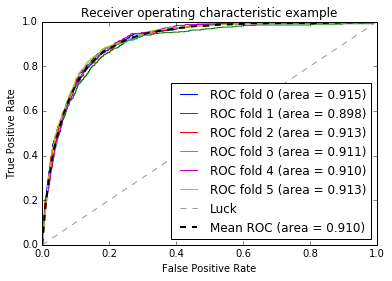

In [10]:
# AdaBoost
evaluate_model(AdaBoostClassifier(n_estimators=500))

Calculating fold: 1 2 3 4 5 6 done!

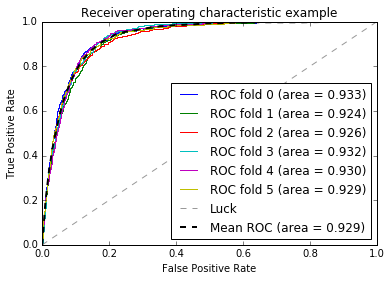

In [11]:
# Gradient Boosting
evaluate_model(GradientBoostingClassifier(n_estimators=500))

Calculating fold: 1 2 3 4 5 6 done!

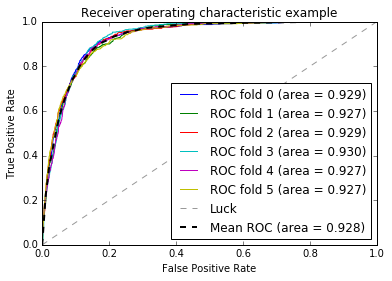

In [12]:
# Random Forest
evaluate_model(RandomForestClassifier(n_estimators=2000, n_jobs=multiprocessing.cpu_count()))

## 結論

- GBDTとRFが最も良い
    - 計算速度も考慮すると、RFの方に軍配（並列化できるので）